<a href="https://colab.research.google.com/github/kiyong21c/Must_Have_Kaggle/blob/main/20221218_plant-pathology_model_fc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 병든 잎사귀 식별 경진대회
 - 미션 : 잎사귀가 어떤 질병에 걸렸는지 식별
 - 유형 : 다중분류
 - 평가지표 : ROC AUC
 - 사용모델 : EfficientNet-B7(사전훈련 모델)
 - 주요내용
   > Albumentations(이미지 변환기)

   > TTA(테스트단계 데이터 증강)

   > 레이블 스무딩
   
   > 스케쥴러(학습률 갱신)


In [ ]:
# 이전 프로젝트의 train, test 파일 삭제
import shutil

shutil.rmtree('/content/drive/MyDrive/Colab Notebooks/train')
shutil.rmtree('/content/drive/MyDrive/Colab Notebooks/test')

In [2]:
import os
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/plan-pathology-2020-fgvc7/plant-pathology-2020-fgvc7.zip'

if os.path.isdir('/content/images'):   # 이미 압축을 푼 폴더가 있는지 확인
    pass
else:   # 이미 압축푼 파일이 없으면 실행
    from zipfile import ZipFile

    with ZipFile(data_path) as zipper:
        zipper.extractall()

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
train.shape, test.shape

((1821, 5), (1821, 1))

In [3]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [4]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [ ]:
submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


### 데이터 시각화

#### 타깃값 분포
 - 각 타깃값에 해당하는 데이터가 몇 개씩인지 알아보자

In [5]:
import matplotlib.pyplot as plt
import os
print(os.getcwd()) # /content
os.chdir('/content/drive/MyDrive/Colab Notebooks') # Colab Notebooks 폴더 넣어놓은 자체제작 MatplotlibKor 라이브러리 사용하기 위함
from MatplotlibToKor import * # 
print(os.getcwd()) # /content/drive/MyDrive/Colab Notebooks

/content
/content/drive/MyDrive/Colab Notebooks


In [6]:
# 데이터를 타깃값별로 추출
healthy = train.loc[train['healthy']==1]
multiple_diseases = train.loc[train['multiple_diseases']==1]
rust = train.loc[train['rust']==1]
scab = train.loc[train['scab']==1]

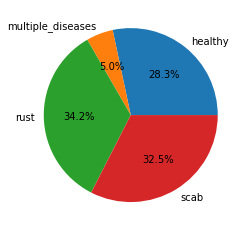

In [7]:
label = ['healthy', 'multiple_diseases','rust','scab'] # 타깃값 레이블

plt.pie([len(i) for i in [eval(i) for i in label]],
        labels=label,
        autopct='%.1f%%');

In [8]:
# 문자열(String)을 변수명(Variable)으로 전환 : eval(문자열)
label = ['healthy', 'multiple_diseases','rust','scab']

label_list = [eval(i) for i in label]   # list comprehension 이용

 - multiple_diseases의 비율이 많이 작다
 - 훈련/검증 데이터 나눌 때 타깃값 비율을 유지한채 나눠줘야 함

#### 이미지 출력

In [9]:
import matplotlib.gridspec as gridspec
import cv2

def show_image(img_ids, title=None, rows=2, cols=3):
    assert len(img_ids) <= rows * cols # 이미지가 행 * 열 개수보다 작아야 실행

    plt.figure(figsize=(15, 8)) # state-based
    plt.suptitle(title) # 전체의 제목설정
    grid = gridspec.GridSpec(rows, cols)

    # 이미지 출력
    for idx, img_id in enumerate(img_ids):
        img_path = f'/content/images/{img_id}.jpg' # 이미지 파일 경로
        image = cv2.imread(img_path)               # 이미지 파일 읽기
        imgae = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        ax = plt.subplot(grid[idx]) # state-based → object-oriented
        # ax = fig.add_subplot : plt와 fig의 차이에 유의
        # fig, axes = plt.subplots : fig와 axes를 함께 return함에 유의
        ax.imshow(image)

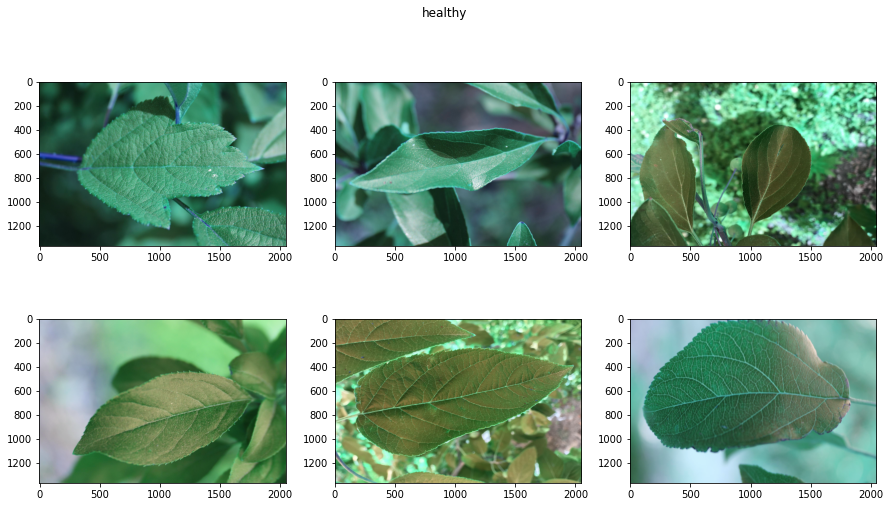

In [10]:
# 각 타깃값별 image_id(마지막 6개만)
num_of_imgs = 6
# last_healthy_img_ids

show_image(healthy['image_id'][-num_of_imgs:], title='healthy')

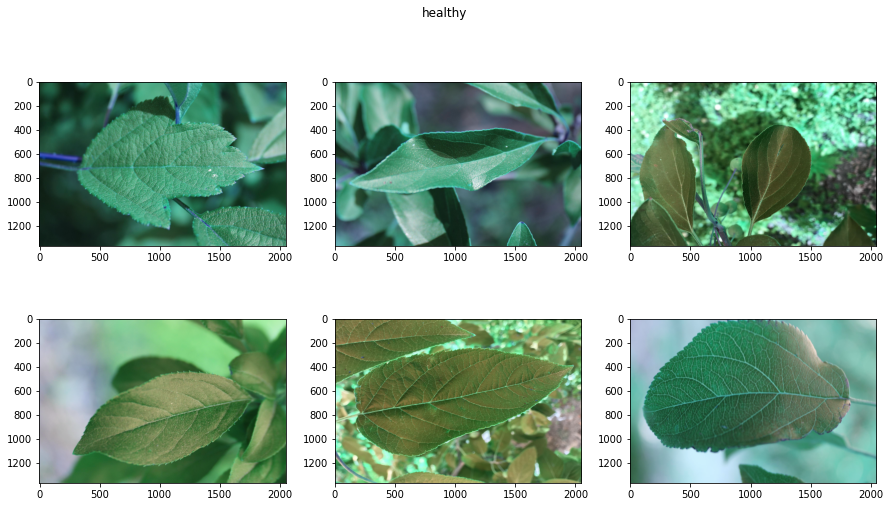

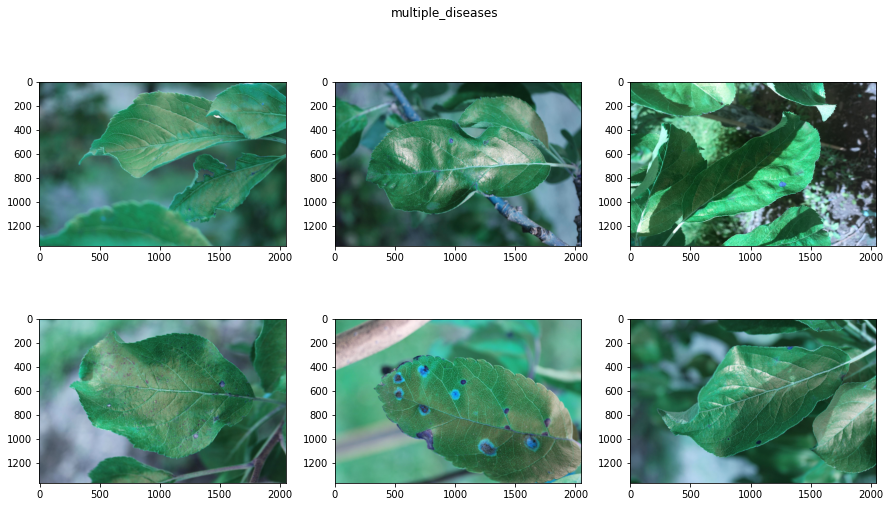

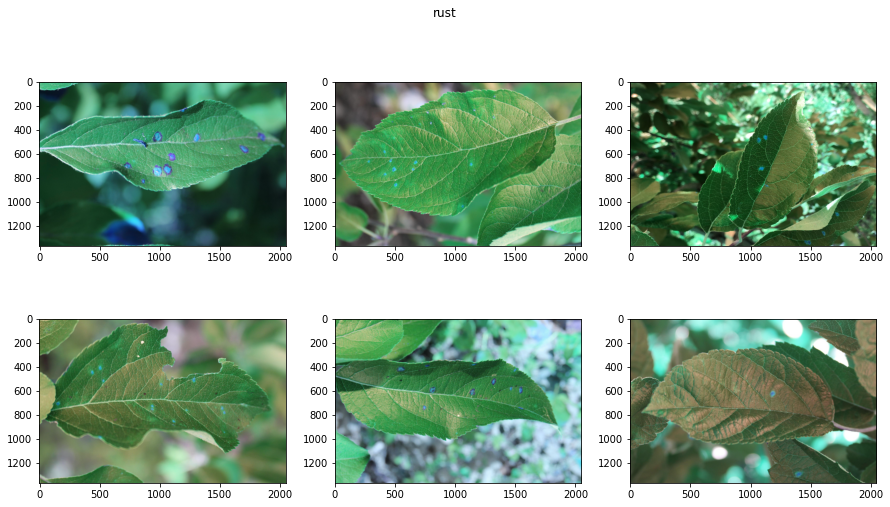

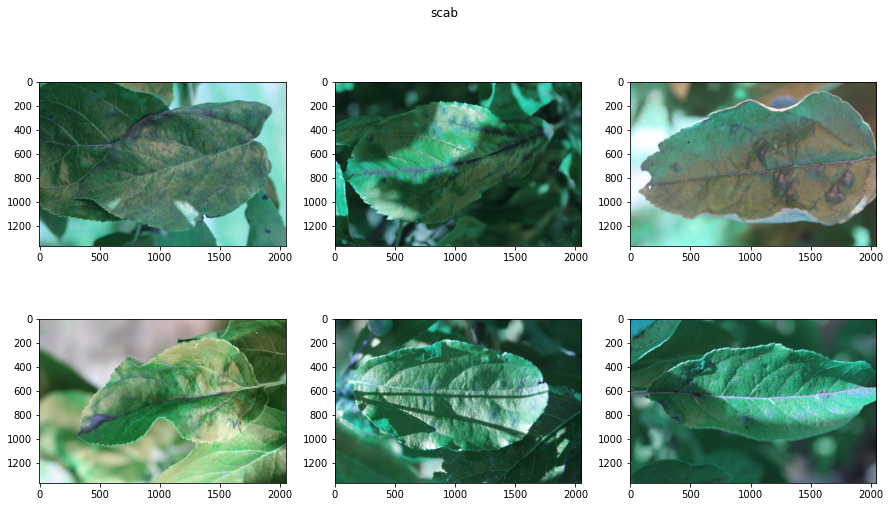

In [ ]:
# 각 타깃값별 image_id(마지막 6개만)
num_of_imgs = 6
# last_healthy_img_ids

for i in label: # label = ['healthy', 'multiple_diseases','rust','scab']
    var = eval(i)   # String → Variable
    show_image(var['image_id'][-num_of_imgs:], title=i)

## 베이스라인 모델
 - 데이터 증강 : 다양한 변환기 적용
 - 신경망 모델 : 사전훈련 모델(Efficientnet-b7)
 - 옵티마이저 : AdamW

### 시드값 고정 및 GPU 장비 설정
 - 다시 실행해도 같은 결과를 얻기 위함
 - 머신러닝 훈련시 random_state와 같은 역할

In [11]:
# 아래 임포트한 패키지 및 seed 함수를 라이브러리로 저장(SeedFix폴더의 seedfix파일의 seed함수)
import torch
import random
import numpy as np
import os

# 시드값 고정
def seed(seed=50):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)               # 파이썬 난수 생성기 시드 고정
    np.random.seed(seed)            # 넘파이 난수 생성기 시드 고정
    torch.manual_seed(seed)         # 파이토치 난수 생성기 시드 고정(CPU 사용 시)
    torch.cuda.manual_seed(seed)    # 파이토치 난수 생성기 시드 고정(GPU 사용 시)
    torch.cuda.manual_seed_all(seed)# 파이토치 난수 생성기 시드 고정(멀티GPU 사용 시)
    torch.backends.cudnn.deterministic = True # 확정적 연산 사용
    torch.backends.cudnn.benchmark = False    # 벤치마크 기능 해제
    torch.backends.cudnn.enabled = False      # cudnn 사용 해제
    print('시드값 고정 완료')

In [12]:
from SeedFix.seedfix import *

#### GPU 장비 설정

In [13]:
# 조건문 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [14]:
# 한줄 조건문
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 코랩 환경 설정이 되어있는상태여야함

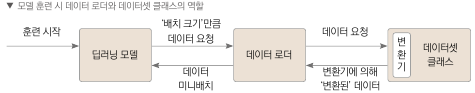

### 데이터 준비

#### 훈련 데이터, 검증 데이터 분리


In [15]:
from sklearn.model_selection import train_test_split

# 훈련/검증 데이터 분리
train, valid = train_test_split(train,
                                test_size=0.1,          # 훈련데이터90%, 검증데이터10%
                                stratify=train[label],  # 동일한 타깃값 비율을 갖도록 split 
                                random_state=50)

In [16]:
print('훈련 데이터 개수 :', len(train))
print('검증 데이터 개수 :', len(valid))

훈련 데이터 개수 : 1638
검증 데이터 개수 : 183


#### 데이터셋 클래스 정의
 - 파이토치로 신경망 모델을 구축하기 위함

In [17]:
import cv2
from torch.utils.data import Dataset # 추상클래스(를 상속받아 특수메서드 오버라이딩)
import numpy as np

class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None, is_test=False):  # is_test : True/False에 따라 __getitem__메서드에서 if 조건문을 통해 test데이터인경우 label반환X
        super().__init__()  # 부모(추상)클래스인 Dataset의 __init__()메서드 호출

        # 전달받은 인수들 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    # 데이터셋 크기 반환 메서드
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 및 레이블 반환 메서드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]                  # 이미지 ID
        img_path = self.img_dir + img_id + '.jpg'      # 이미지 파일경로
        image = cv2.imread(img_path)                   # 이미지 파일읽기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상보정

        # 이미지 변환
        if self.transform is not None:
            # image = self.transform(image) # torchvision 모듈에서 제공하는 transform
            image = self.transform(image=image)['image'] # albumentations 모듈에서 제공하는 transform
        if self.is_test:
            return image # 테스트용일 때(훈련X검증X)
        else:
            # 타깃값 4개 중 가장 큰 값의 인덱스 : healthy면 0, multiple_disease면 1, rust면 2, scab면 3
            label = np.argmax(self.df.iloc[idx, 1:5])
            return image, label

#### Albumentation 기본적인 사용방법 및 파라미터
 - augmentations = transform(image=image, mask=mask)를 이용하여 실제 Augmentation을 적용합니다.

 - augmentation_img = augmentations["image"]를 이용하여 Augmentation된 이미지를 얻을 수 있습니다.

 [Albumentation : 링크 텍스트](https://gaussian37.github.io/dl-pytorch-albumentation/#albumentation%EC%9D%98-%EA%B8%B0%EB%B3%B8%EC%A0%81%EC%9D%B8-%EC%82%AC%EC%9A%A9-%EB%B0%A9%EB%B2%95-1)

### 이미지 변환기 정의

In [18]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [19]:
# 훈련 데이터용 변환기
transform_train = A.Compose([A.Resize(450, 650),
                             A.VerticalFlip(p=0.2), # 20% 확률로 변환기 적용
                             A.HorizontalFlip(p=0.5),
                             A.Normalize(),         # 정규화
                             ToTensorV2()])         # torchvision.transform과 달리 Tensor변환을 마지막에
# 검증 및 테스트 데이터용 변환기
transform_test = A.Compose([A.Resize(450, 650),
                            A.Normalize(),
                            ToTensorV2()])

#### 데이터셋 생성

In [20]:
dataset_train = ImageDataset(df=train, img_dir='train/', transform=transform_train)
dataset_valid = ImageDataset(df=valid, img_dir='train/', transform=transform_test)

#### 파이썬의 특징인 일급객체 이해하기
 - 1. 함수를 변수에 담아서 변수()로 사용할 수 있다.
 - 2. 함수1을 함수2의 파라미터에 넣을 수 있다(괄호 없이 사용)
 - 3. 함수1을 함수2의 리턴값으로 사용할수 있다(괄호 포함 사용)


#### 괄호 없이 함수를 사용하는 경우 이해하기
  - 1. 함수 뒤에 붙는 괄호는 그 함수를 호출하겠다는 뜻
  - 2. 함수는 정의를 한다고 해서 바로 실행되는 것이 아니다. 정의 후에 꼭 불러주는 작업이 있어야 실행됨
  - 3. 함수도 하나의 객체이며, 만약 괄호 없이 사용했다면 그저 함수 객체 그 자체로 넘겼다는 뜻

[링크 텍스트](https://blog.naver.com/qkdqkd1122/222880930740)

  - 4. 사용 예제

    ```
def str_length(s):
        return len(s)
max('a', 'abc', 'ab', key=str_length)
# str_length('a') → 1
# str_length('abc') → 3
# str_length('ab') → 2
# max(1, 3, 2) → 3 즉, 'abc'가 return됨
    ```
    ```
# str_length함수가 즉시 실행되는 것이 아니라,
# max함수 내부에서 순서대로 호출되면서,
# 중간결과 값을 저장하며, max함수의 인자로 사용됨
    ```

 [링크 텍스트](https://hashcode.co.kr/questions/7489/python%EC%97%90%EC%84%9C-%EC%96%B8%EC%A0%9C-%EA%B4%84%ED%98%B8%EB%A5%BC-%EC%8D%A8%EC%95%BC-%ED%95%98%EB%82%98%EC%9A%94)

#### 데이터 로더 생성
 - 데이터셋 생성 → 데이터 로더 생성
 - 지정한 배치크기만큼 데이터를 불러오는 객체
 - 멀티프로세싱 사용

In [21]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [22]:
from torch.utils.data import DataLoader

batch_size = 4  # 훈련데이터가 1,821개로 많지 않아 배치크기 4로 작게 설정

loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True,
                          worker_init_fn=seed_worker, generator=g, num_workers=2) # 한번호출시 4개의 이미지를 불러옴
loader_valid = DataLoader(dataset=dataset_valid, batch_size=batch_size, shuffle=False,
                          worker_init_fn=seed_worker, generator=g, num_workers=2)

#### 전역변수와 지역변수
 - 1. 지역변수는 전역변수로 나오지 못한다

    ```
    a = 10
    def test(b, c):
        a = b + c
        return a

    print(a) # 10 : 함수내에서 정의된 지역변수 a는 전역으로 나오지 못한다.
    ```


 - 2. 전역변수를 지역변수로 가져와서 수정가능하며, 전역변수에 영향을 준다

    ```
    a = 10
    def test(b, c):
        global a    # 전역변수를 지역변수로 가져옴
        a = b + c
        return a
        
    print(test(1, 2)) # 3 : 전역변수 a를 지역변수로 가져와서 수정하면 전역에 영향을 준다.
    ```

### 모델 생성
 - 사전 훈련된 모델을 전이 학습
 - 데이터셋(클래스) 정의/생성 → 데이터로더 생성 → 모델(클래스) 정의/생성 → 손실함수,옵티마이저 설정 → 모델 훈련

#### 파이토치로 사전 훈련 모델 이용방법
 - 1.torchvision.models 모듈 이용
 - 2.pretrainedmodels 모듈 이용
 - 3.직접 구현한 모듈 이용


#### Efficient 모델 생성

In [23]:
pip install efficientnet-pytorch==0.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=de1b29f0da387aef0a7dc2ed4de6f079a4f2abe9878f01d2a81d5514b4f2015b
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet-pytorch


In [24]:
from efficientnet_pytorch import EfficientNet

In [25]:
# 사전 훈련된 모델 불러오기
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=4) # num_classes : 최종 출력값 개수
# 타깃값이 1,000개인 이미지넷 데이터로 사전 훈련한 모델이므로, num_classes를 지정하지 않으면, 최종 출력값이 1,000개가 됨

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7


In [26]:
model = model.to(device)

#### efficientnet-b7의 출력값 개수를 설정하는 다른 방법
 - 모델의 fc layer에 접근 : model._fc

```
model._fc # 모델의 fc레이어에 접근 : Linear(in_features=2560, out_features=4, bias=True)

import torch.nn as nn
model = EfficientNet.from_pretrained('efficientnet-b7') # default 출력값은 1,000개

# 불러온 efficientnet-b7모델의 마지막 계층 수정
model._fc = nn.Sequential(nn.Linear(model._fc.in_features, model._fc.out_features),  # 2560 → 1000
                          nn.ReLU(),
                          nn.Dropout(p=0.5),
                          nn.Linear(model._fc.out_features, 4)) # 1000 → 4
```



### 모델 훈련 및 성능 검증

20221218_______________

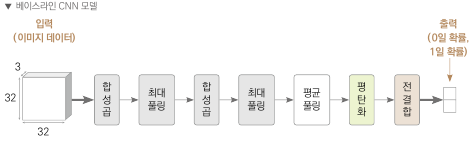

In [ ]:
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈에서 자주사용되는 함수를 모아둔 모듈

In [ ]:
class Model(nn.Module): # 신경망 모듈(추상클래스)를 상속받음 : __init__(), forward() 두가지 오버라이딩 해야함
    # 신경망 계층 정의
    def __init__(self): # Model()클래스로 인스턴스 객체생성시 파라미터를 아무것도 받지 않음
        super().__init__() # 상속받은 nn.Module의 __init__() 메서드 호출
    
        # 첫번째 합성곱 계층
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)

        # 두번째 합성곱 계층
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)

        # 최대 풀링 계층
        self.max_pool = nn.MaxPool2d(kernel_size=2)

        # 평균 풀링 계층
        self.avg_pool = nn.AvgPool2d(kernel_size=2)

        # 전결합(fc) 계층(layer)
        self.fc = nn.Linear(in_features=64 * 4 * 4, out_features=2)
        # 최종 channel은 CNN Layer정의하면서 정해놓은 값(64), 최종 가로세로 크기는 정의한 Layer로 계산해본 값(4)
    
    # 순전파 출력 정의 : 출력값 얻기위해 인스턴스.forward()로 직접 호출하는 것은 아님
    ## nn.Module 추상클래스의 내부적 로직에 의해 입력값을 받게 되면 forward 메서드가 동작함
    def forward(self, x):   # 상속받은 nn.Module의 forward() 메서드를 재정의함 
        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = self.avg_pool(x)
        x = x.view(-1, 64 * 4 * 4) # -1 : 이후 배치사이즈를 조절할경우 자유롭게 대응하기 위함
        x = self.fc(x)
        return x    # (배치사이즈, 2)

In [ ]:
model = Model().to(device)

#### Model 클래스를 정의하는 또 다른 방법



```
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # 첫번째 Layer
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=32,    # nn.Sequential()로 합성곱연산,활성화함수,최대풀링을 합쳐서 사용
                                              kernel_size=3, padding=2),
                                    nn.ReLU(),                      # nn.functional.relu() vs nn.ReLU()
                                    nn.MaxPool2d(kernel_size=2))
        # 두번째 Layer
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32,out_channels=64,    # nn.Sequential()로 합성곱연산,활성화함수,최대풀링을 합쳐서 사용
                                              kernel_size=3, padding=2),
                                    nn.ReLU(),                      # nn.functional.relu() vs nn.ReLU()
                                    nn.MaxPool2d(kernel_size=2))
        # 평균 풀링 계층
        self.avg_pool = nn.AvgPool2d(kernel_size=2)
        # 전결합 계층
        self.fc = nn.Linear(in_features=64 * 4 * 4, out_features=2)
    # 순전파 출력 정의
    def forward(self, x):   # nn.sequential로 레이어에 많은 기능을 담아서 forward는 비교적 간단
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg_pool(x)
        x = x.view(-1, 64 * 4 * 4)
        x = self.fc(x)
        return x
```



#### 클래스의 인스턴스를 생성하고 이후 인스턴스에 파라미터를 입력시 로직
 - Model(nn.Module)클래스로 model 인스턴스 생성하고
 - output = model(input)시 내부적으로 forward(self, x)메서드가 수행되는 로직
 - 1. def $__call__$/(self): 매직메서드 정의
 - 2. $__call__$ = forward

 [링크 텍스트](https://ddiri01.tistory.com/374)



```
class test():
    def __init__(self, a=1):  # __init__() should return None, not 'int' 
        self.t = a
    
    # 인스턴스가 호출 가능하도록 하는 매직메서드
    def __call__(self):  # t = test() 인스턴스 정의 후 t() 등으로 호출하려면 __call__() 정의되야함
        print('call됨')

    def forward(self, b):
        return self.t + b
    
    # 인스턴스가 호출시 함수를 실행 시키는 기능
    __call__ = forward # 함수명

t = test()
t(10)
# 11
```



In [ ]:
class test():
    def __init__(self, a=1):  # __init__() should return None, not 'int' 
        self.t = a
    
    # 인스턴스가 호출 가능하도록 하는 매직메서드
    def __call__(self):  # t = test() 인스턴스 정의 후 t() 등으로 호출하려면 __call__() 정의되야함
        print('call됨')

    def forward(self, b):
        return self.t + b
    
    # 인스턴스가 호출시 함수를 실행 시키는 기능
    __call__ = forward # 함수명

In [ ]:
t = test()

In [ ]:
t(10)

11

### 모델 훈련
 - 훈련에 앞서 손실함수, 옵티마이저 설정

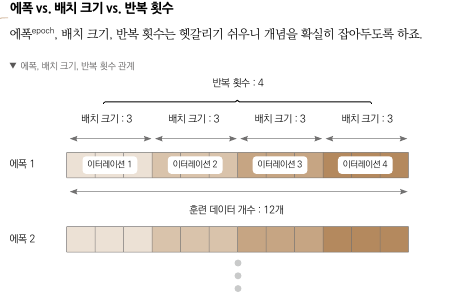

In [ ]:
len(loader_train) # 데이터 로더의 길이로 반복횟수 구할 수 있음

493

#### 손실 함수 설정
 - 신경망 모델 훈련 : 가중치를 갱신
 - 가중치 갱신 : 예측값과 실제값의 손실값이 작아지는 방향으로 갱신
 - 손실값을 구하는 함수 = 손실 함수

In [ ]:
# 손실 함수
criterion = nn.CrossEntropyLoss() # 교차엔트로피 : 분류 문제에 주로 사용

#### 옵티마이저 설정
 - 모델의 가중치를 입력받는다

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # 배치 마다 새로운 모델의 가중치를 파라미터로 받게됨

In [ ]:
%%time 
# 모델 훈련시 16min 이상 소요됨

import os

model_save_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/Aerial-Cactus-Identification/model_base_dict.pt'


if os.path.isfile(model_save_path): # 훈련후 저장한 모델이 있으면 모델 훈련X
    print(f'이미 훈련한 모델이 있음 \n {model_save_path}')
    model = Model() # 모델 생성
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print(f'이미 훈련한 모델(GPU) 불러오기 완료')
    pass
else:

    epochs = 10 # 총 에폭
    # '총 에폭'만큼 반복
    for epoch in range(epochs):
        epoch_loss = 0 # 에폭별 손실 값 초기화

        # '반복 횟수' 만큼 반복(=이터레이션)
        for idx, (images, labels) in enumerate(loader_train): 
        # ImageDataset 정의할 때 __getitem__() 메서드의 return 값 → image, label
        # DataLoader 생성할 때 ImageDataset으로 생성한 dataset_train 객체를 파라미터로 받음
            images = images.to(device)
            labels = labels.to(device)

            # 옵티마이저 내 기울기 초기화
            optimizer.zero_grad() # model.weight.grad → None

            # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용하여 출력값 계산
            outputs = model(images) # Model(nn.Module)클래스로 생성한 인스턴스인 model에 images로 호출(__call__)
            # nn.Module 부모(추상)클래스의 __call__ 메서드를 통해 오버라이딩된 forward 메서드를 호출함

            # 손실 함수를 활용해 outputs와 labels의 손실값 계산
            loss = criterion(outputs, labels) # nn.CrossEntropy()클래스로 생성한 인스턴스인 criterion에 outputs, labels로 호출(__call__)

            # 현재 배치에서의 손실 추가
            epoch_loss += loss.item()

            # 역전파 수행
            loss.backward() # model.parameters()의 가중치의 .grad 어트리뷰트에 계산된 기울기가 저장됨
            # print(len(list(model.parameters()))) # 가중치는 총 6개

            # 가중치 갱신
            optimizer.step() # model.parameters()의 가중치의 .grad 어트리뷰트에 접근해 가중치를 갱신함
            # model.weight 또는 model.bias로 갱신된 가중치 및 편향을 확인할 수 있음
            
            # 반복당(이터레이션) 손실
            if idx % 50 == 0:
                print(f'에폭 [{epoch+1}/{epochs}], 이터레이션 [{idx+1}/{len(loader_train)}] - 손실값 : {loss:.4f}')
        # 에폭당 평균 손실값(반복당 손실의 합 / 반복횟수) 출력
        print(f'에폭 [{epoch+1}/epochs] - 손실값 : {epoch_loss/len(loader_train):.4f}')

    # 전체 에폭 훈련후 모델 저장
    torch.save(model.state_dict(), model_save_path)

에폭 [1/10], 이터레이션 [1/493] - 손실값 : 0.7389
에폭 [1/10], 이터레이션 [51/493] - 손실값 : 0.6712
에폭 [1/10], 이터레이션 [101/493] - 손실값 : 0.4591
에폭 [1/10], 이터레이션 [151/493] - 손실값 : 0.4396
에폭 [1/10], 이터레이션 [201/493] - 손실값 : 0.6247
에폭 [1/10], 이터레이션 [251/493] - 손실값 : 0.5267
에폭 [1/10], 이터레이션 [301/493] - 손실값 : 0.5917
에폭 [1/10], 이터레이션 [351/493] - 손실값 : 0.4560
에폭 [1/10], 이터레이션 [401/493] - 손실값 : 0.4379
에폭 [1/10], 이터레이션 [451/493] - 손실값 : 0.5401
에폭 [1/epochs] - 손실값 : 0.5233
에폭 [2/10], 이터레이션 [1/493] - 손실값 : 0.4146
에폭 [2/10], 이터레이션 [51/493] - 손실값 : 0.3652
에폭 [2/10], 이터레이션 [101/493] - 손실값 : 0.4277
에폭 [2/10], 이터레이션 [151/493] - 손실값 : 0.2909
에폭 [2/10], 이터레이션 [201/493] - 손실값 : 0.3468
에폭 [2/10], 이터레이션 [251/493] - 손실값 : 0.3160
에폭 [2/10], 이터레이션 [301/493] - 손실값 : 0.3493
에폭 [2/10], 이터레이션 [351/493] - 손실값 : 0.1368
에폭 [2/10], 이터레이션 [401/493] - 손실값 : 0.2703
에폭 [2/10], 이터레이션 [451/493] - 손실값 : 0.2520
에폭 [2/epochs] - 손실값 : 0.3453
에폭 [3/10], 이터레이션 [1/493] - 손실값 : 0.4280
에폭 [3/10], 이터레이션 [51/493] - 손실값 : 0.3977
에폭 [3/10], 이터레이션 [101/493] 

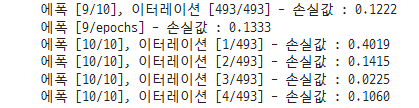

 - 다음 에폭으로 넘어갈때 수정된 가중치를 가지고 넘어가지만
 - 1에폭에서 2에폭으로 가는 즉시 무조건 손실값이 줄어들어야 하는건 아니다
 - 1에폭(데이터 전체를 한번 학습)을 통해 가중치가 조금씩 수정되어, 학습 데이터 전체에 대해 가중치가 스무스하게 맞춰짐
 - 2에폭의 첫 이터레이션(1에폭에서 학습했던 이터레이션이지만)에서 가중치가 수정될 여지가 충분히 있음(즉, 손실이 있을 수 있음) 
 - 그러나, 에폭이 반복 될수록(학습데이터 전체를 다시 한번 다 읽어 올수록) 이전 에폭보다 더욱 빠르게 손실값을 줄이는 방향으로 가중치가 갱신됨

#### 모델 Save & Load 2가지 방법
 - 1. state_dict()로 모델의 파라미터만 Save → 동일한 모델 구조를 생성한 뒤 파라미터 Load
 - 2. 모델을 통째로 Save → 통째로 Load

In [ ]:
model # 모델 출력시 나타나는 정보

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)

In [ ]:
model.state_dict().keys() # 모델.sate_dict() 출력시 나타나는 각 layer 마다의 parameters(weight, bias)

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc.weight', 'fc.bias'])

In [ ]:
# 모델 저장(파라미터만)
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/kaggle/input/Aerial-Cactus-Identification/model_base_dict.pt')

In [ ]:
# 모델 생성
model2 = Model()

In [ ]:
# 모델 로드(파라미터만)
model2.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/kaggle/input/Aerial-Cactus-Identification/model_base_dict.pt'))

<All keys matched successfully>

In [ ]:
# 모델 저장(통째로)
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/kaggle/input/Aerial-Cactus-Identification/model_base_all.pt')

In [ ]:
# 모델 로드(통째로)
model_new = torch.load('/content/drive/MyDrive/Colab Notebooks/kaggle/input/Aerial-Cactus-Identification/model_base_all.pt')


```
# backward() 메서드의 기능 확인 : 가중치에 .grad 어트리뷰트 값 저장
w = torch.tensor(2.0, requires_grad=True)

epochs = 5
for epoch in range(epochs):
    y = 2 * w
    y.backward() # 텐서는 backward() 메서드 사용 가능 : torch.tensor클래스에 backward()메서드 있음
    print(f'y를 w로 미분한 값(기울기) :{w.grad}')   # w.grad : 가중치의 어트리뷰트에 기울기가 저장됨
    # 기울기 초기화를 하지 않으면 반복문을 통해 w.grad가 계속 더해짐

```
[backward(), .grad, zero_grad() : 링크 텍스트](https://blog.naver.com/dbwjd516/222874331187)


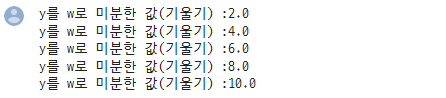

#### zero_grad(), backward(), step() 메서드의 동작 확인



 - 간단한 Linear Regression 모델로 각 메서드 동작 확인
 
```
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(0)

x_train = torch.FloatTensor([[1], [2], [3]])
y_train = torch.FloatTensor([[2], [4], [6]])
# "y=2x에 가깝게" 모델이 학습하게 될 것

model = nn.Linear(in_features=1, out_features=1) # 

# print(list(model.parameters())) # [w, b] → 두 가중치 모두 requires_grad=True : 자동미분기능 적용

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs =100
for epoch in range(epochs):

    # 순전파
    outputs = model(x_train)

    # 손실값 계산
    loss = F.mse_loss(outputs, y_train)

    # 기울기 초기화
    optimizer.zero_grad() # 가중치.grad → None
    # print(list(model.parameters())[0].grad) # w.grad → None

    # 역전파
    loss.backward()
    # print(len(list(model.parameters()))) # 가중치는 두개 : w, b
    # print(f'가중치 : {model.weight.data}, 편향 : {model.bias.data}') # w 가중치(업데이트 전), b 편향(업데이트 전)
    # print(f'dloss/dw : {model.weight.grad}, dloss/db : {model.bias.grad}') # dloss/dw, dloss/db : 기울기가 .grad에 저장됨

    # 가중치 업데이트
    optimizer.step()
    # print(f'가중치 : {model.weight.data}, 편향 : {model.bias.data}') # w 가중치(업데이트 전), b 편향(업데이트 전)
    # print(f'{epoch+1}번 epoch의 loss : {loss.item()}')

    if epoch % 10 == 0:
        print(f'손실값 Loss : {loss:.4f}')
```
[backward() : 링크 텍스트](https://github.com/pytorch/pytorch/blob/35bd2b3c8b64d594d85fc740e94c30aa67892a34/torch/autograd/__init__.py)

[step() : 링크 텍스트](https://github.com/pytorch/pytorch/blob/cd9b27231b51633e76e28b6a34002ab83b0660fc/torch/optim/sgd.py#L63)


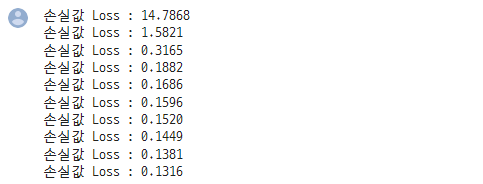

### 성능 검증
 - 검증 데이터를 이용해 평가지표인 ROC AUC 값 구해보자
 - 실제값을 얼마나 잘 예측하나 확인

In [ ]:
from sklearn.metrics import roc_auc_score # 사이킷런 제공 함수
# 실제값과 예측 확률값을 담을 리스트 초기화 : ROC AUC 계산을 위해
true_list = [] # 실제값
preds_list = [] # 예측값

In [ ]:
model.eval() # 모델을 평가 상태로 설정 : 모델에 드롭아웃이나, 배치 정규화 적용이 없어 사실상 없어도 됨

model = model.to(device)
with torch.no_grad(): # 기울기 계산 비활성화 : with문 내 사실 backward()가 없기 때문에 기울기 계산 할일 없음
    try:    # loader_valid를 호출하면 에러발생하여 try문으로 예외무시함
        for idx, (images, labels) in enumerate(loader_valid): # error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor' 
            images = images.to(device)
            labels = labels.to(device) # device에 위치한 model의 입력으로 사용하지 않으므로 불필요
            # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
            outputs = model(images)

            # 사이킷런 함수인 roc_auc_score는 GPU에 있는 데이터 연산 불가 : .cpu()
            preds = torch.softmax(outputs.cpu(), dim=1)[:, 1] # "1"을 예측할 확률 (32, 1)
            true = labels.cpu()

            # 예측 확률과 실제값을 리스트에 추가
            preds_list.extend(preds) # extend() : 배치를 풀어서 리스트에 넣는다
            true_list.extend(true)
    except:
        print('끝')
        print(len(loader_valid), '번 반복')

# 검증 데이터 ROC AUC 점수 계산
print(f'검증 데이터 ROC AUC : {roc_auc_score(true_list, preds_list)}')

끝
55
검증 데이터 ROC AUC : 0.9924085576259489


In [ ]:
len(true_list)

1568

In [ ]:
len(preds_list)

1568

#### torch.softmax(data, dim=) 작동원리


```
a = torch.Tensor([[0.1], [0.5], [0.7]])
b = torch.Tensor([[0.7], [0.5], [0.1]]).T
```


```
print(a, a.shape) # [3, 1]
print(b, b.shape) # [1, 3]

>> tensor([[0.1000],
        [0.5000],
        [0.7000]]) torch.Size([3, 1])
>> tensor([[0.7000, 0.5000, 0.1000]]) torch.Size([1, 3])
```


```
torch.softmax(a, dim=0) # 2차원인 경우, dim=0는 세로축(row단위) 합이 1

>> tensor([[0.2318],
        [0.3458],
        [0.4224]])
```


```
torch.softmax(b, dim=1) # 2차원인 경우, dim=1는 가로축(col단위) 합이 1

>> tensor([[0.4224, 0.3458, 0.2318]])
```



```
# 배치 차원 추가하는 방법(numpy or torch)
np.expand_dims(a, axis=0).shape # numpy.expand_dims(data, axis=0) → array
torch.unsqueeze(a, dim=0).shape # torch.unsqueeze(data, dim=0) → torch

>> torch.Size([1, 3, 1])
```


```
torch.softmax(torch.unsqueeze(a, dim=0), dim=1) # 3차원(배치 차원 추가되어)인 경우, dim=1은 세로축(row단위) 합이 1

>> tensor([[[0.2318],
         [0.3458],
         [0.4224]]])
```











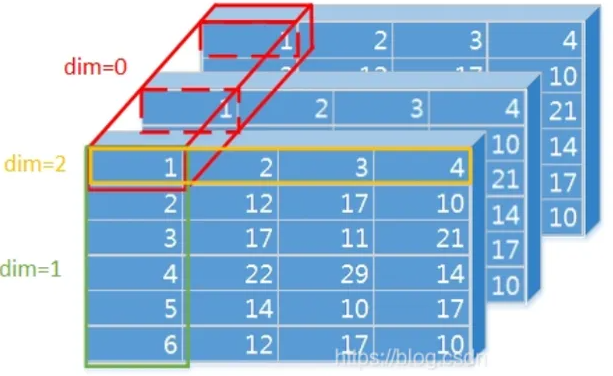

#### torch.no_grad() 메서드의 동작 확인


```
w = torch.tensor(2.0, requires_grad=True) # True나 False로 적용해도 .grad는 (None으로) 생성됨
z = 2 * w # w의 함수인 z또한 requires_grad=True

with torch.no_grad():   # with문 내에서 모든 torch에 "자동미분그래프"를 저장하지 않는다
    epochs = 5
    for epoch in range(epochs):
        y = 2 * w
        print(w.requires_grad)  # with torch.no_grad() 내에서도 requires_grad=True → True
        print(y.requires_grad)  # with torch.no_grad() 적용시 requires_grad=True → False
        y.backward() # 에러 발생
```



#### list.extend() vs list.append()


```
list_a = []
list_b = []

for i in range(3):
    add = [1,2,3]
    list_a.extend(add)  # extend : 리스트를 열어서 요소를 추가
    list_b.append(add)  # append : 리스트 그대로 추가

print(list_a)
print(list_b)

>> [1, 2, 3, 1, 2, 3, 1, 2, 3]
>> [[1, 2, 3], [1, 2, 3], [1, 2, 3]]
```



## 성능 개선
 - 1. 다양한 이미지 변환
 - 2. 더 깊은 CNN 모델
 - 3. 더 뛰어난 옵티마이저
 - 4. 훈련시 에폭 수 증가

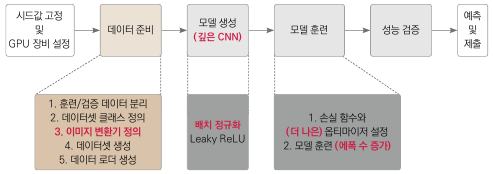

### 데이터 준비
#### 이미지 변환과 데이터 증강
#### 이미지 변환기 정의
 - 훈련 데이터용 : 다양한 변환 적용
 - 검증 및 테스트 데이터용 : 최소한의 변환 적용

In [ ]:
from torchvision import transforms # 이미지 변환을 위한 모듈

# 훈련 데이터용 변환기
# ImageDataset(Dataset) 클래스의 __getitem__(self, transform=None)메서드에 의해 cv2.imread()로 읽어온 img에 적용하게됨
transform_train = transforms.Compose([transforms.ToTensor(),    # cv2이미지 → Tensor
                                      transforms.Pad(32, padding_mode='symmetric'),    # 대칭 패딩
                                      transforms.RandomHorizontalFlip(),                # 받아온 이미지중 50%만 무작위로  좌우대칭
                                      transforms.RandomVerticalFlip(),                  # 받아온 이미지중 50%만 무작위로  상하대칭
                                      transforms.RandomRotation(10),                    # 받아온 이미지를 -10~+10도 무작위로 회전
                                      transforms.Normalize((0.485, 0.456, 0.406),       # RGB 3가지 각각 평균과 분산 : 백만개 이상의 이미지 보유한 이미지넷의 데이터로 부터 얻은 평균과 분산임
                                                            (0.229, 0.224, 0.225))])
# 검증 및 테스트 데이터용 변환기
transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Pad(32, padding_mode='symmetric'),
                                     transforms.Normalize((0.485, 0.456, 0.406),
                                                          (0.229, 0.224, 0.225))])

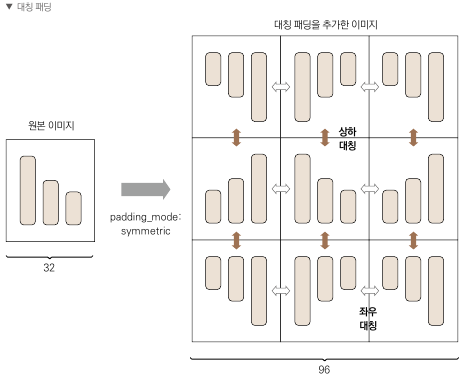

#### 데이터셋 생성

In [ ]:
### 데이터 증강 이해하기 ###
# 데이터셋의 image가 __getitem__에 의해 batch단위로 transform되어 return됨
# __getitem__의 idx는 batch단위로 불려지므로 batch마다 다른 transform의 확률이 적용됨
# __getitem__의 idx는 DataLoader()에 의해 중복되지 않게 불려짐
# 따라서, 새로운 에폭에서 동일한 원본 이미지라도 다른 transform의 확률이 적용됨
dataset_train = ImageDataset(df=train, img_dir='train/', transform=transform_train)
dataset_valid = ImageDataset(df=valid, img_dir='train/', transform=transform_test)

#### 데이터 로더 생성

In [ ]:
# 데이터 로더는 파라미터의 dataset을 배치단위로(중복되지 않게) 호출함
from torch.utils.data import DataLoader
loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

### 모델 생성
 - 신경망 계층이 깊어지면 > 예측력이 좋아짐 > 과대적합 우려 유의
 - 배치 정규화 추가적용(합성곱과 최대풀링 사이단계)
 - Leaky ReLU 변경(기존 : ReLU)

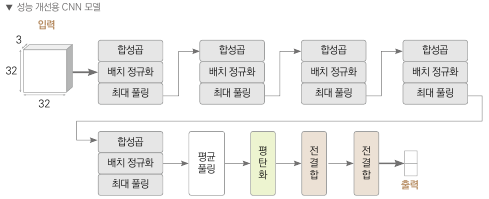

In [ ]:
# nn.Sequential() 활용해 신경망 계층 설계

import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈의 주요 사용 함수

class Model(nn.Module):
    # 신경망 계층 정의
    def __init__(self):
        super().__init__() # 상속받은 nn.Module의 __init__()메서드 호출

        # 초기 이미지 shape (32, 3, 96, 96) : transforms에서 크기가 32인 패딩을 추가함
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2),
                                    nn.BatchNorm2d(32),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2),
                                    nn.BatchNorm2d(64),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.avg_pool = nn.AvgPool2d(kernel_size=4)

        # 전결합 계층
        self.fc1 = nn.Linear(in_features=512 * 1 * 1, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=2)

    # 순전파 출력 정의
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg_pool(x)
        x = x.view(-1, 512 * 1 * 1) # 평탄화 : (32, 512, 1, 1) → (32, 512)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

#### 배치 정규화의 기능
 - 의미 : 배치크기(ex. 32개의 데이터)를 가져오면 배치내 데이터간의 편차를 줄여줌
 - FC에서는 이전 레이어를 통과하면서 편중된 데이터의 분포를 정규분포로 만들어서 다음레이어의 입력으로 사용
 - CNN에서는 배치내 각 채널 끼리의 평균/분산 계산하여 정규분포로 만듦
 
[BatchNorm2d : 링크 텍스트](https://blog.naver.com/qhruddl51/222459607565)

In [ ]:
# 배치 정규화의 기능
import torch
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈의 주요 사용 함수

H = 10
W = 10

input = torch.randn(4, 3, H, W) # batch_size : 4, channel_size : 3
bn = nn.BatchNorm2d(3) # channel : 3
output = bn(input)
print(output.shape) # [4, 3, W, H] : H, W 가 바뀜

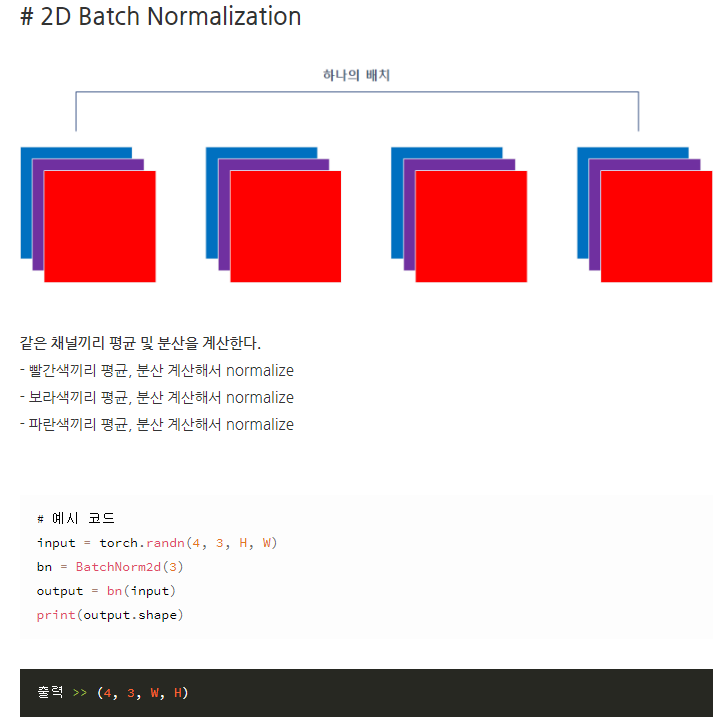

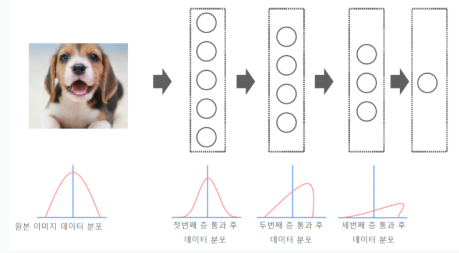

#### # 1D Batch Normalization

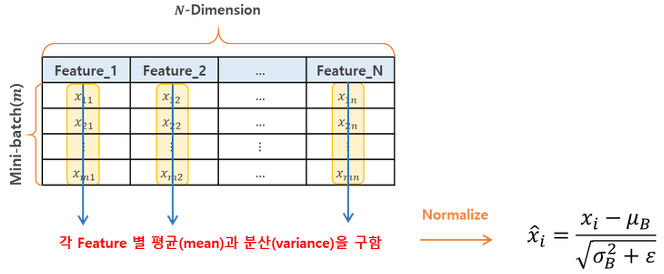

In [ ]:
# 배치 정규화의 기능
import torch
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈의 주요 사용 함수

H = 10
W = 10

input = torch.randn(4, 3, H, W) # batch_size : 4, channel_size : 3
bn = nn.BatchNorm2d(3) # channel : 3
output = bn(input)
print(output.shape) # [4, 3, W, H] : H, W 가 바뀜

### 모델 훈련
 - 배치 크기를 작게하면, 학습률도 작게 설정
 - 배치 크기 작다 : 한번에 학습하는 이미지의 양이 작다
 - 이미지의 분포에 따라 대세에 따른 가중치의 조정이 아니게 될 수 있으므로, 가중치의 그라디언트가 크게 튀지 않도록 파라미터를 세밀하게 조절해야 한다

In [ ]:
# 모델 생성
model = Model().to(device)
# 손실함수 생성
criterion = nn.CrossEntropyLoss()
# 옵티마이저 생성
optimizer = torch.optim.Adamax(model.parameters(), lr=0.00006) # 배치 크기가 줄어들수록 학습률도 작게 설정

#### 모델 훈련

In [ ]:
%%time
import time
epochs = 10

# 총 에폭만큼 반복 : 전체 데이터를 몇번 반복할지
for epoch in range(epochs):
    epoch_loss = 0 # 에폭별 손실값 초기화

    # epoch당 소요 시간 계산
    start = time.time()
    # '반복 횟수'만큼 반복 : 전체 데이터를 '배치 크기'로 나눈 수
    for images, labels in loader_train:
        images = images.to(device)
        labels = labels.to(device)

        # 옵티마이저 내 기울기 초기화 : backward()수행시 마다 '가중치.grad'가 += 되지 않도록
        optimizer.zero_grad()
        # 순전파
        outputs = model(images)
        # 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item() # 배치 단위마다 loss가 더해지므로 평균을 내야함
        # 역전파
        loss.backward() # loss을 가중치로 미분(Chain Rule적용)하여 '가중치.grad'에 저장
        # 가중치 갱신
        optimizer.step() # model.parameters() 즉, 파라미터인 가중치에 접근하여 갱신
    end = time.time()
    print(f'{end - start:.3f} sec')
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 손실값 : {epoch_loss/len(loader_train):.4f}')

torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/kaggle/input/Aerial-Cactus-Identification/model_transforms.pt')

KeyboardInterrupt: ignored

In [ ]:
model = Model()
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/kaggle/input/Aerial-Cactus-Identification/model_transforms.pt', map_location=device))
model = model.to(device) ##### GPU로 불러와서 사용하려면 반드시 설정! : 이문제로 2일 고생함...

### 성능 검증

In [ ]:
from sklearn.metrics import roc_auc_score

true_list = []
preds_list = []

#### 불러온 모델을 GPU에서 사용하려면 model.to(device) 반드시 설정하고 사용해야함
model.eval() # 모델을 평가상태로 설정

with torch.no_grad(): # 기울기 계산 비활성화
    try:
        for images, labels in loader_valid:

            images = images.to(device)
            labels = labels.to(device)

            # 순전파
            outputs = model(images)

            preds = torch.softmax(outputs.cpu(), dim=1)[:, 1] # 1을 예측할 확률값 : roc_auc_score에서는 예측한 label을 넣으면 안된다
            true = labels.cpu() # 실제값

            # 예측 확률값과 실제값을 리스트에 추가(extend)
            preds_list.extend(preds) # list.extend() : 배치크기를 풀어서 넣음
            true_list.extend(true)
            
    except:
        print('종료')
# 검증 데이터 ROC AUC 점수 계산
print(f'검증 데이터 ROC AUC : {roc_auc_score(true_list, preds_list)}')

종료
224 224
검증 데이터 ROC AUC : 0.9960563935719216
